In [1]:
%cd ../..

g:\Projects\feature-selection-breast-cancer-dataset


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import LinearSVC

from src.utils.correlation_calculator import get_irrelevant_features
from src.utils.metrics import FeatureSelectionMethod, MetricsManager
from src.utils.models import create_random_forest_classifier
from src.utils.wrappers import select_features_from_model, train_rfe_wrapper
from src.utils.preprocess import preprocess_data
from src.utils.train_and_evaluate import train_and_evaluate_rfc



### Data Loading and Inspection

In [3]:
cancer_df = pd.read_csv("data/breast_cancer_data.csv")
cancer_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
cancer_df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


In [5]:
cancer_df.dtypes

id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

### Preprocessing - Step 1: Removing Null Features

In [6]:
cancer_df.isnull().sum().sort_values(ascending=False).head()

Unnamed: 32                569
compactness_se               0
fractal_dimension_worst      0
symmetry_worst               0
concave points_worst         0
dtype: int64

- `Unanamed: 32` is a useless column

In [7]:
drop_cols = ["id", "Unnamed: 32"]
cancer_df = cancer_df.drop(drop_cols, axis=1)

cancer_df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Preprocessing - Step 2:  Label Encoding

In [8]:
cancer_df.diagnosis.value_counts()

diagnosis
B    357
M    212
Name: count, dtype: int64

- `M` represents malignant
- `N` represents benign

In [9]:
cancer_df["diagnosis"] = (cancer_df["diagnosis"] == "M").astype(int)

In [10]:
cancer_df.diagnosis.value_counts()

diagnosis
0    357
1    212
Name: count, dtype: int64

In [11]:
X = cancer_df.drop("diagnosis", axis=1)
y = cancer_df["diagnosis"]


In [12]:
X.shape, y.shape

((569, 30), (569,))

### Baseline Model Training

In [13]:
metrics_all_features = train_and_evaluate_rfc(X, y)
metrics_all_features

Metrics(accuracy=0.9649122807017544, roc_score=0.9672619047619049, precision=0.9318181818181818, recall=0.9761904761904762, f1=0.9534883720930233, num_features=30)

In [14]:
metrics_manager = MetricsManager()

In [15]:
metrics_manager.comparison_df

""


In [16]:
metrics_manager.update(metrics_all_features, FeatureSelectionMethod.ALL)
metrics_manager.comparison_df

,accuracy,roc_score,precision,recall,f1,num_features
All Features,0.964912,0.967262,0.931818,0.97619,0.953488,30


### Correlation filtering # 1 - Strong Features

- Let's filter features based on their degree of correlation with the target variable
- Only features with correlation values above the threshold will be selected

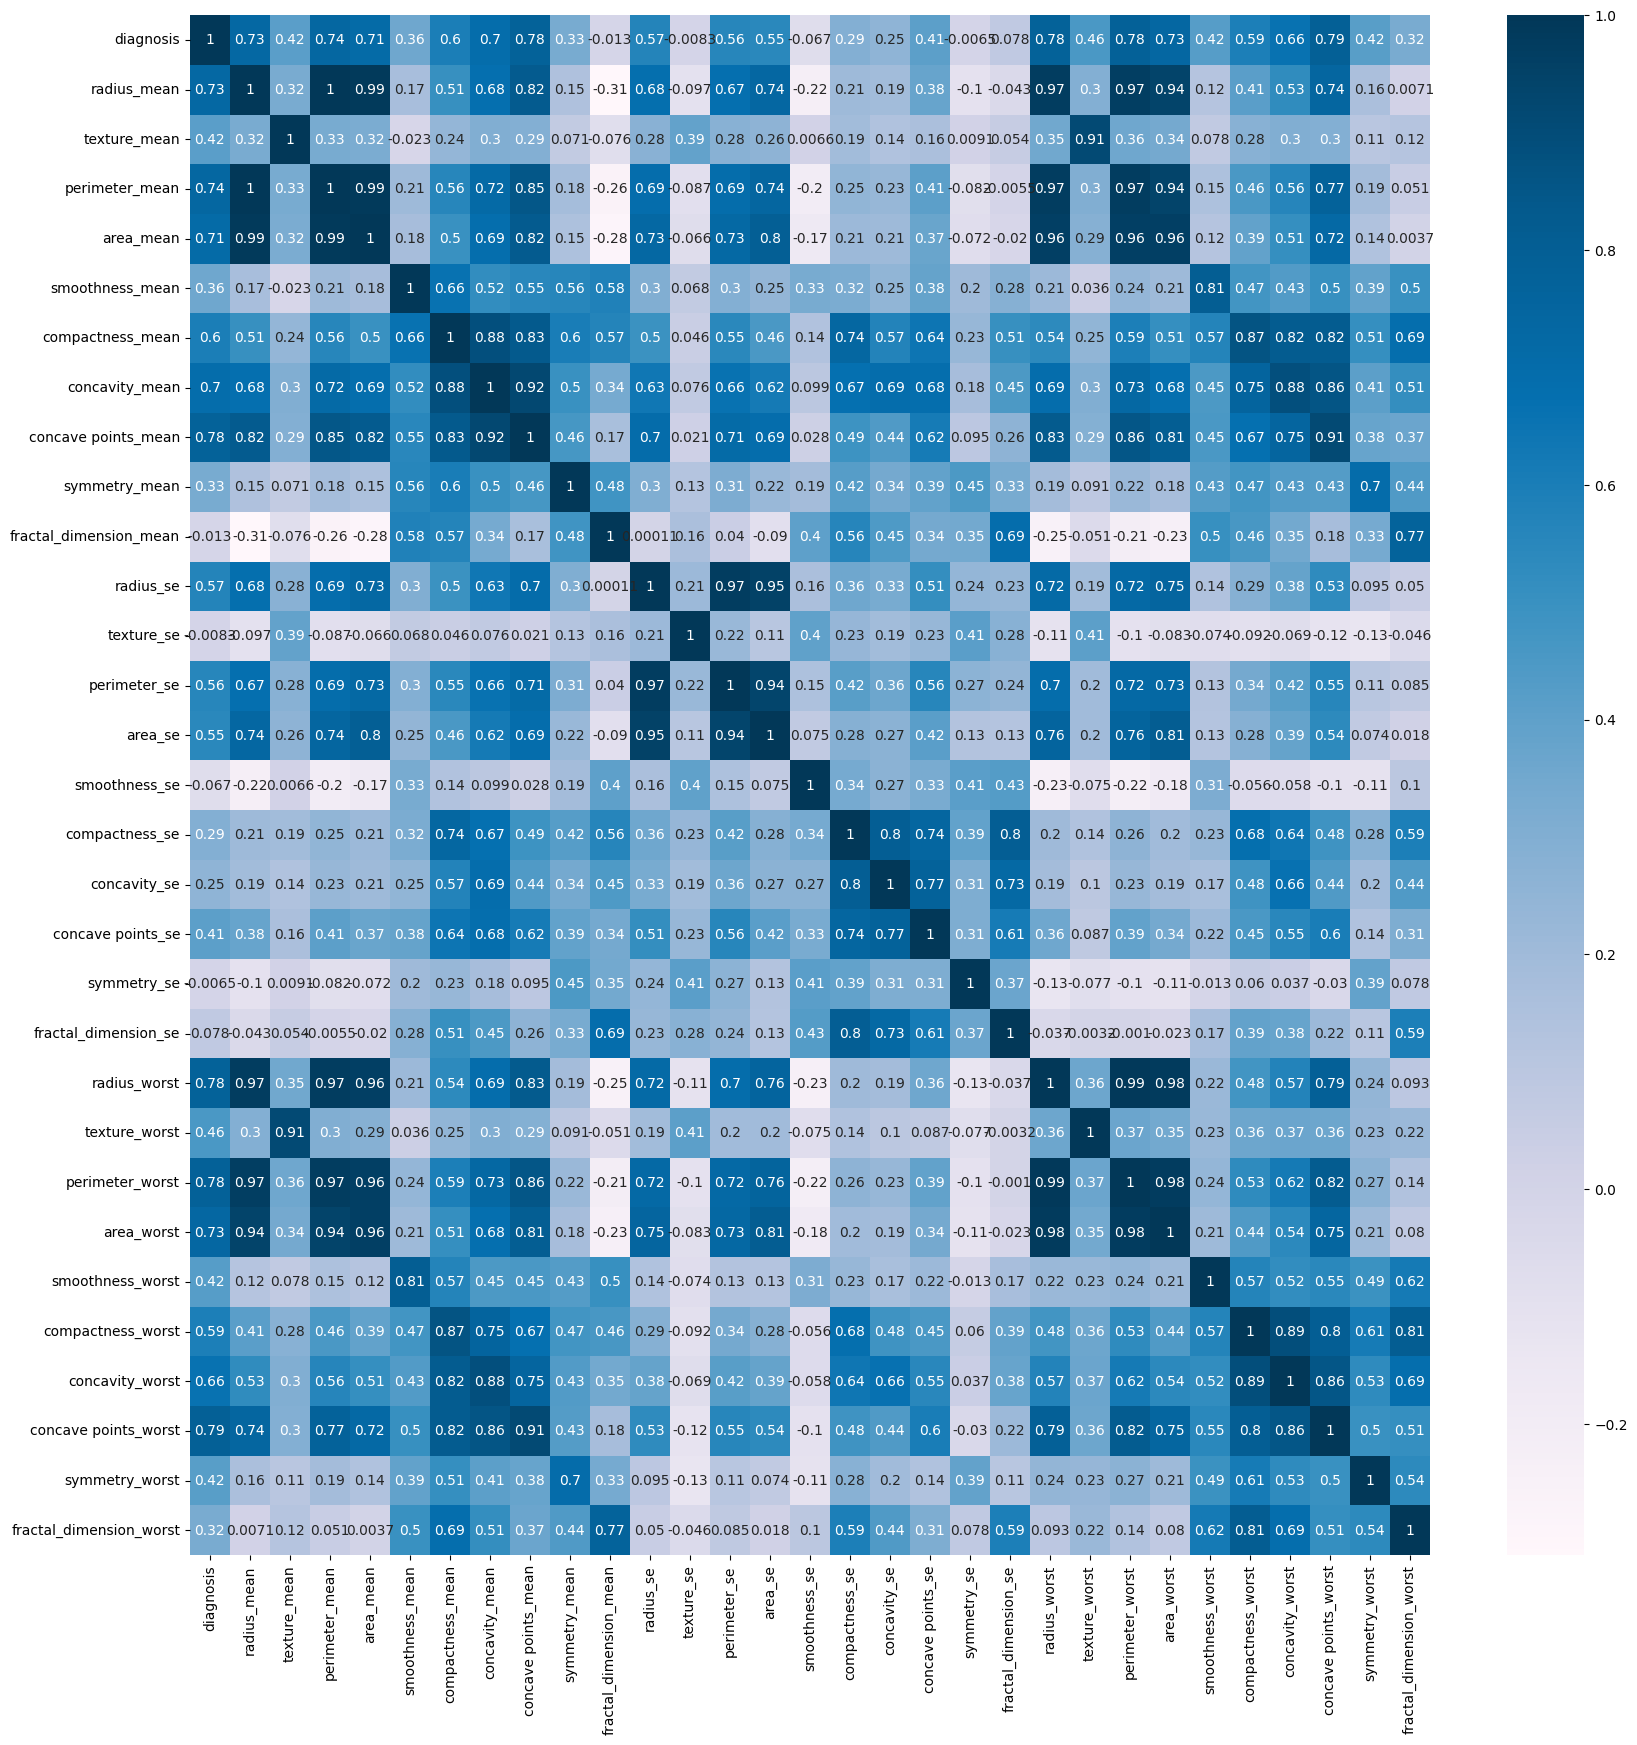

In [17]:
plt.figure(figsize=(20,20))

corr_df = cancer_df.corr() 

sns.heatmap(corr_df, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [18]:
CORRELATION_THRESHOLD = 0.2

In [19]:
corr_df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
diagnosis,1.000000,0.730029,0.415185,0.742636,0.708984,0.358560,0.596534,0.696360,0.776614,0.330499,...,0.776454,0.456903,0.782914,0.733825,0.421465,0.590998,0.659610,0.793566,0.416294,0.323872
radius_mean,0.730029,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,...,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
texture_mean,0.415185,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,...,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
perimeter_mean,0.742636,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,...,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
area_mean,0.708984,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,...,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738


In [20]:
highly_correlated_with_target = corr_df["diagnosis"][abs(corr_df["diagnosis"]) > CORRELATION_THRESHOLD]
strong_features = highly_correlated_with_target.index.to_list()
strong_features.remove("diagnosis")
print(strong_features)


['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'radius_se', 'perimeter_se', 'area_se', 'compactness_se', 'concavity_se', 'concave points_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


In [21]:
metrics_strong_features = train_and_evaluate_rfc(X[strong_features], y)
metrics_strong_features

Metrics(accuracy=0.9736842105263158, roc_score=0.9742063492063492, precision=0.9534883720930233, recall=0.9761904761904762, f1=0.9647058823529412, num_features=25)

In [22]:
metrics_manager.update(metrics_strong_features, FeatureSelectionMethod.STRONG)
metrics_manager.comparison_df

,accuracy,roc_score,precision,recall,f1,num_features
All Features,0.964912,0.967262,0.931818,0.97619,0.953488,30
Strong Features,0.973684,0.974206,0.953488,0.97619,0.964706,25


### Correlation filtering # 2: Non - correlated features

- Let's filter features based on their degree of correlation with each other
- Features which are highly correlated with other features will be deemed irrelevant
- In each case we will keep the feature which has the high correlation with the target variable

In [23]:
irrelevant_features = get_irrelevant_features(corr_df, "diagnosis", 0.95)

<Axes: >

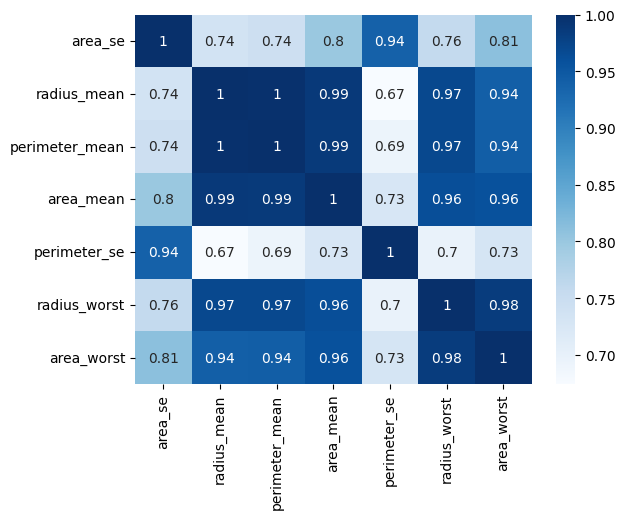

In [24]:
sns.heatmap(X[irrelevant_features].corr(), annot=True, cmap=plt.cm.Blues)
# We sea a lot of strong correlations between the irrelevant features

In [25]:
metrics_non_correlated_features = train_and_evaluate_rfc(X.drop(irrelevant_features, axis=1), y)
metrics_manager.update(metrics_non_correlated_features, FeatureSelectionMethod.NON_CORRELATED)
metrics_manager.comparison_df

,accuracy,roc_score,precision,recall,f1,num_features
All Features,0.964912,0.967262,0.931818,0.976190,0.953488,30
Strong Features,0.973684,0.974206,0.953488,0.976190,0.964706,25
Non - Correlated Features,0.973684,0.969246,0.975610,0.952381,0.963855,23


### Correlation filtering # 3 - Strong non - correlated features

- Let's filter the correlated filters from the list of strong features

In [26]:
strong_relevant_features = [feat for feat in strong_features if feat not in irrelevant_features]
metrics_strong_relevant_features = train_and_evaluate_rfc(X[strong_relevant_features], y)


In [27]:
metrics_manager.update(metrics_strong_relevant_features, FeatureSelectionMethod.STRONG_NON_CORRELATED)

In [28]:
metrics_manager.comparison_df

,accuracy,roc_score,precision,recall,f1,num_features
All Features,0.964912,0.967262,0.931818,0.976190,0.953488,30
Strong Features,0.973684,0.974206,0.953488,0.976190,0.964706,25
Non - Correlated Features,0.973684,0.969246,0.975610,0.952381,0.963855,23
Strong Non - Correlated Features,0.956140,0.955357,0.930233,0.952381,0.941176,18


### Univariate Feature Selection # 1: `f_classif`

In [29]:
selector = SelectKBest(f_classif, k=20)
best_k_features_f_classif = selector.fit_transform(X, y)

In [30]:
metrics_f_classif = train_and_evaluate_rfc(best_k_features_f_classif, y)

In [31]:
metrics_manager.update(metrics_f_classif, FeatureSelectionMethod.F_STAT_SELECTED)

In [32]:
metrics_manager.comparison_df

,accuracy,roc_score,precision,recall,f1,num_features
All Features,0.964912,0.967262,0.931818,0.976190,0.953488,30
Strong Features,0.973684,0.974206,0.953488,0.976190,0.964706,25
Non - Correlated Features,0.973684,0.969246,0.975610,0.952381,0.963855,23
Strong Non - Correlated Features,0.956140,0.955357,0.930233,0.952381,0.941176,18
F-stat Filtered Features,0.973684,0.974206,0.953488,0.976190,0.964706,20


### Wrapper Method #1 - Recursive Feature Elimination

In [33]:
processed_data = preprocess_data(X, y)
model = create_random_forest_classifier()
rfe = train_rfe_wrapper(model, processed_data.X_train_scaled, processed_data.y_train, n_features_to_select=20) 

In [34]:
rfe_best_20 = cancer_df.drop("diagnosis", axis=1).columns[rfe.get_support()].to_list()
rfe_best_20

['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'concavity_mean',
 'concave points_mean',
 'symmetry_mean',
 'area_se',
 'compactness_se',
 'concavity_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst',
 'symmetry_worst',
 'fractal_dimension_worst']

In [35]:
metrics_rfe_best_20 = train_and_evaluate_rfc(X[rfe_best_20], y)
metrics_rfe_best_20

Metrics(accuracy=0.9649122807017544, roc_score=0.9672619047619049, precision=0.9318181818181818, recall=0.9761904761904762, f1=0.9534883720930233, num_features=20)

In [36]:
metrics_manager.update(metrics_rfe_best_20, FeatureSelectionMethod.RFE)

In [37]:
metrics_manager.comparison_df

,accuracy,roc_score,precision,recall,f1,num_features
All Features,0.964912,0.967262,0.931818,0.976190,0.953488,30
Strong Features,0.973684,0.974206,0.953488,0.976190,0.964706,25
Non - Correlated Features,0.973684,0.969246,0.975610,0.952381,0.963855,23
Strong Non - Correlated Features,0.956140,0.955357,0.930233,0.952381,0.941176,18
F-stat Filtered Features,0.973684,0.974206,0.953488,0.976190,0.964706,20
RFE Selected Features,0.964912,0.967262,0.931818,0.976190,0.953488,20


### Embedded Methods # 1 - Feature Importances

In [38]:
model = create_random_forest_classifier()
model.fit(processed_data.X_train_scaled, processed_data.y_train)

RandomForestClassifier(criterion='entropy', random_state=100)

In [39]:
rfc_selected_important_features = select_features_from_model(model, X.columns.to_list(), model_params={"prefit":True, "threshold":0.013})
print(rfc_selected_important_features)

['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'area_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst']


In [40]:
metrics_rfc_selected_important_features = train_and_evaluate_rfc(X[rfc_selected_important_features], y)

In [41]:
metrics_manager.update(metrics_rfc_selected_important_features, FeatureSelectionMethod.RANDOM_FOREST)

In [42]:
metrics_manager.comparison_df

,accuracy,roc_score,precision,recall,f1,num_features
All Features,0.964912,0.967262,0.931818,0.976190,0.953488,30
Strong Features,0.973684,0.974206,0.953488,0.976190,0.964706,25
Non - Correlated Features,0.973684,0.969246,0.975610,0.952381,0.963855,23
Strong Non - Correlated Features,0.956140,0.955357,0.930233,0.952381,0.941176,18
F-stat Filtered Features,0.973684,0.974206,0.953488,0.976190,0.964706,20
RFE Selected Features,0.964912,0.967262,0.931818,0.976190,0.953488,20
RFC Selected Important Features,0.964912,0.967262,0.931818,0.976190,0.953488,16


### Embedded Methods # 2 - L1 Regularization

In [43]:
model = LinearSVC(C=1, penalty="l1", dual=False)
model.fit(processed_data.X_train_scaled, processed_data.y_train)
l1_selected_features = select_features_from_model(model, X.columns.tolist(), {"prefit": True})
print(l1_selected_features)

['compactness_mean', 'concavity_mean', 'symmetry_mean', 'radius_se', 'texture_se', 'area_se', 'smoothness_se', 'compactness_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'smoothness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


In [44]:
metrics_l1_selected_features = train_and_evaluate_rfc(X[l1_selected_features], y)

In [45]:
metrics_l1_selected_features

Metrics(accuracy=0.9473684210526315, roc_score=0.943452380952381, precision=0.9285714285714286, recall=0.9285714285714286, f1=0.9285714285714286, num_features=18)

In [46]:
metrics_manager.update(metrics_l1_selected_features, FeatureSelectionMethod.L1)

In [49]:
metrics_manager.comparison_df
metrics_manager.comparison_df.style.highlight_max(axis=0)

,accuracy,roc_score,precision,recall,f1,num_features
All Features,0.964912,0.967262,0.931818,0.976190,0.953488,30
Strong Features,0.973684,0.974206,0.953488,0.976190,0.964706,25
Non - Correlated Features,0.973684,0.969246,0.975610,0.952381,0.963855,23
Strong Non - Correlated Features,0.956140,0.955357,0.930233,0.952381,0.941176,18
F-stat Filtered Features,0.973684,0.974206,0.953488,0.976190,0.964706,20
RFE Selected Features,0.964912,0.967262,0.931818,0.976190,0.953488,20
RFC Selected Important Features,0.964912,0.967262,0.931818,0.976190,0.953488,16
L1 Selected Important Features,0.947368,0.943452,0.928571,0.928571,0.928571,18
